In [14]:
import torch
import numpy as np
from typing import Dict, Any, List
import torch.nn.functional as F
from model.model import MoEModel

# Set device
if torch.cuda.is_available():
    DEVICE = 'cuda'
else:
    DEVICE = 'cpu'

# Classifying Expert Weights (Ortho, Superposition, etc)
Implementation for n=2 and n=3 (each a separate function).

In [15]:
import torch
from helpers.helpers.helpers import classify_expert_weights_2d

# Sample expert weights with 2 features, 1 hidden dim
expert_weights_2d = torch.tensor([[[ 0.2857],
                                   [ 0.3748]],
                                  [[-0.9991],
                                   [ 0.4402]]])

# Classify and print results
classifications = classify_expert_weights_2d(expert_weights_2d)
print("\nExpert Weight Classifications (2D):")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")

ModuleNotFoundError: No module named 'helpers.helpers.helpers'; 'helpers.helpers' is not a package

In [ ]:
import torch
from helpers.helpers import classify_expert_weights_n3

# Sample expert weights with 3 features, 2 hidden dims (equiv. to model.W_experts)
expert_weights_3d = torch.tensor([
    # Expert 0
    [[ 0.7071,  0.0000],  # Feature 0: [hidden_dim_0, hidden_dim_1]
        [ 0.7071,  0.0000],  # Feature 1: [hidden_dim_0, hidden_dim_1] 
        [ 0.0000,  1.0000]], # Feature 2: [hidden_dim_0, hidden_dim_1]
    
    # Expert 1
    [[ -0.5774,  0.5774],  # Feature 0: [hidden_dim_0, hidden_dim_1]
        [ -0.5774,  -0.5774],  # Feature 1: [hidden_dim_0, hidden_dim_1]
        [ 0.5774, -0.5774]]  # Feature 2: [hidden_dim_0, hidden_dim_1]
])
    
# Classify and print results
classifications = classify_expert_weights_n3(expert_weights_3d)
print("\nExpert Weight Classifications:")
for expert_id, result in classifications.items():
    print(f"\n{expert_id}:")
    for i, hidden_result in enumerate(result['hidden_dimensions']):
        print(f"  Hidden dim {i}: {hidden_result['classification']} (similarity: {hidden_result['similarity']:.3f})")
        print(f"    Weights: {hidden_result['weights']}")
        if hidden_result['pattern']:
            print(f"    Pattern: {hidden_result['pattern']}")


Expert Weight Classifications:

expert_0:
  Hidden dim 0: superposition_pair_feature_0_feature_1_positive (similarity: 1.000)
    Weights: [0.707099974155426, 0.707099974155426, 0.0]
    Pattern: [1.0, 1.0, 0.0]
  Hidden dim 1: orthogonal_feature_2 (similarity: 1.000)
    Weights: [0.0, 0.0, 1.0]
    Pattern: [0.0, 0.0, 1.0]

expert_1:
  Hidden dim 0: superposition_all_three_mixed (similarity: 1.000)
    Weights: [-0.5774000287055969, -0.5774000287055969, 0.5774000287055969]
    Pattern: [1.0, 1.0, -1.0]
  Hidden dim 1: superposition_all_three_mixed (similarity: 1.000)
    Weights: [0.5774000287055969, -0.5774000287055969, -0.5774000287055969]
    Pattern: [-1.0, 1.0, 1.0]


# Compute Router Probabilities

Given weight matrix, likelihood expert is activated via sampling. 

In [ ]:
import torch
from helpers.helpers import compute_all_expert_probabilities, compute_router_probabilities
from model.model import MoEModel, Config, optimize

def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=3,
        n_hidden=2,
        n_experts=4,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1 for _ in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

model = create_model()
optimize(model, n_batch=512, steps=3000, print_freq=250, lr=1e-3)

# Example usage:
print("Gate matrix:")
print(model.gate)

print(f"\nFeature probability: {model.feature_probability.item()}")

# Compute probabilities
prob_with_data, prob_without_data = compute_router_probabilities(
    model.gate, 
    feature_probability=model.feature_probability,
    n_samples=10000
)

print(f"\nRouter probabilities for first expert:")
print(f"With data sparsity: {prob_with_data:.3f}")
print(f"Without data sparsity (uniform): {prob_without_data:.3f}")

Step 0: loss=0.085296, lr=0.001000
Step 250: loss=0.040980, lr=0.001000
Step 500: loss=0.020060, lr=0.001000
Step 750: loss=0.027396, lr=0.001000
Step 1000: loss=0.012560, lr=0.001000
Step 1250: loss=0.015242, lr=0.001000
Step 1500: loss=0.013843, lr=0.001000
Step 1750: loss=0.018273, lr=0.001000
Step 2000: loss=0.015611, lr=0.001000
Step 2250: loss=0.015486, lr=0.001000
Step 2500: loss=0.016638, lr=0.001000
Step 2750: loss=0.010021, lr=0.001000
Step 2999: loss=0.016587, lr=0.001000
Gate matrix:
Parameter containing:
tensor([[-1.9858, -1.9763, -1.9766],
        [ 1.6704,  1.6699,  1.6669],
        [ 1.6706,  1.6696,  1.6613],
        [ 1.6703,  1.6686,  1.6670]], requires_grad=True)

Feature probability: 0.10000000149011612

Router probabilities for first expert:
With data sparsity: 0.202
Without data sparsity (uniform): 0.006


In [39]:
# For multiple experts, you can also compute for each expert:

# Compute for all experts
probs_with_data, probs_without_data = compute_all_expert_probabilities(
    model.gate, 
    feature_probability=model.feature_probability
)

print(f"\nRouter probabilities for all experts:")
for i in range(len(probs_with_data)):
    print(f"Expert {i}: with_data={probs_with_data[i]:.3f}, without_data={probs_without_data[i]:.3f}")


Router probabilities for all experts:
Expert 0: with_data=0.202, without_data=0.006
Expert 1: with_data=0.266, without_data=0.332
Expert 2: with_data=0.266, without_data=0.331
Expert 3: with_data=0.266, without_data=0.331


# Tracker Expert Allocation over Time

Currently only supports for k=1.

Step 0: loss=0.910664, lr=0.001000

Step 50 - Router evolution:
  Expert 0: 23.60%
  Expert 3: 29.50%
  Expert 1: 24.80%
  Expert 2: 22.10%

Step 100 - Router evolution:
  Expert 2: 20.90%
  Expert 0: 28.70%
  Expert 1: 26.80%
  Expert 3: 23.60%

Step 150 - Router evolution:
  Expert 2: 19.20%
  Expert 3: 29.10%
  Expert 0: 22.10%
  Expert 1: 29.60%

Step 200 - Router evolution:
  Expert 0: 23.80%
  Expert 3: 31.30%
  Expert 1: 23.70%
  Expert 2: 21.20%

Step 250 - Router evolution:
  Expert 3: 31.40%
  Expert 1: 21.50%
  Expert 2: 21.60%
  Expert 0: 25.50%
Step 250: loss=0.531920, lr=0.001000

Step 300 - Router evolution:
  Expert 2: 27.70%
  Expert 0: 25.80%
  Expert 1: 25.10%
  Expert 3: 21.40%

Step 350 - Router evolution:
  Expert 2: 18.60%
  Expert 1: 29.80%
  Expert 3: 22.90%
  Expert 0: 28.70%

Step 400 - Router evolution:
  Expert 0: 33.80%
  Expert 3: 31.90%
  Expert 2: 16.60%
  Expert 1: 17.70%

Step 450 - Router evolution:
  Expert 3: 22.00%
  Expert 0: 23.90%
  Expert 1: 3

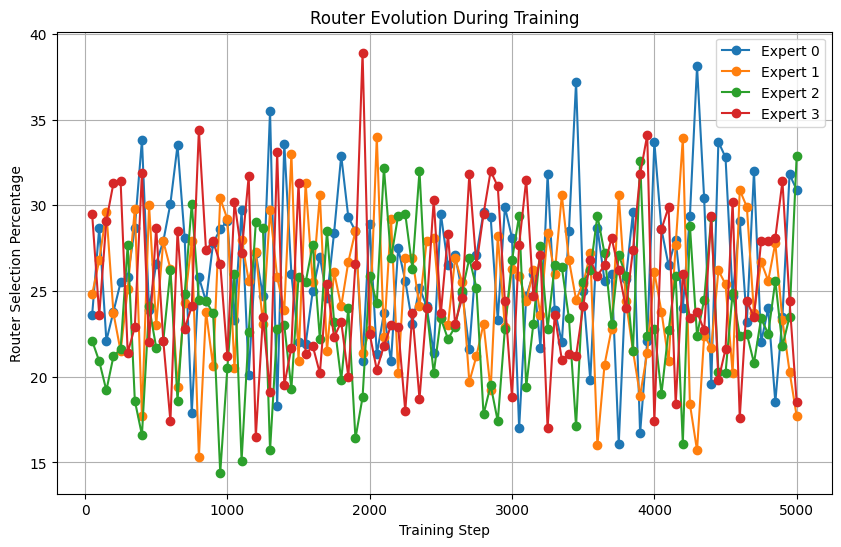

Parameter containing:
tensor([[ 1.5006e-03, -5.0023e-04,  5.2607e-04,  1.5188e-03,  1.8200e-03,
          1.9067e-03,  2.8298e-03,  2.0546e-03,  2.6231e-03,  1.1078e-03,
          3.4099e-03,  8.0179e-04,  2.8968e-03,  1.1537e-03, -1.1265e-03,
          6.6803e-04,  2.4348e-03, -1.4884e-03,  3.0029e-03,  1.8980e-04,
         -2.8757e-03, -5.5414e-04, -1.2110e-03,  2.0283e-03,  2.5961e-03,
         -1.6158e-04,  2.0200e-03,  3.3259e-03,  1.8679e-03,  2.7825e-03,
          2.1801e-03, -6.2010e-04],
        [-1.7362e-03,  1.5442e-03,  4.6892e-04, -3.7802e-03,  1.2050e-03,
          2.3418e-04, -8.3209e-06, -7.4171e-04,  2.0344e-03,  2.6439e-03,
          2.0928e-03,  2.0372e-03,  2.8042e-03,  7.4670e-04,  1.7742e-03,
          2.4161e-03,  1.0761e-03,  6.4407e-04,  7.7320e-04, -2.4070e-04,
          1.0442e-03,  2.5512e-03,  3.5182e-03,  2.4084e-03,  2.2539e-03,
         -1.7441e-03,  3.2678e-03,  7.0453e-04, -5.6481e-04,  1.1178e-03,
          1.3157e-03,  2.0488e-03],
        [ 2.2516e-

In [40]:
import torch
from helpers.helpers import RouterEvolutionHook
from model.model import MoEModel, Config, optimize


def create_model():
    """Train model with router selection tracking."""
    config = Config(
        n_features=32,
        n_hidden=8,
        n_experts=4,
        n_active_experts=1,
        load_balancing_loss=True,
    )
    
    model = MoEModel(
        config=config,
        device=DEVICE,
        # Create a range of values around 1 for importance, length = n_features
        importance = torch.tensor([1 for _ in range(config.n_features)]),
        feature_probability=torch.tensor(0.1)
    )

    return model

# Train with hook
# model = create_model()
# router_hook = RouterSelectionHook()
# optimize(model, n_batch=512, steps=5000, print_freq=100, lr=1e-3, hooks=[router_hook])
# router_hook.print_statistics()

# Or train with evolution tracking
model = create_model()
evolution_hook = RouterEvolutionHook(log_interval=50)
optimize(model, n_batch=512, steps=5000, print_freq=250, lr=1e-3, hooks=[evolution_hook])
evolution_hook.plot_evolution()

print(model.gate)
print(model.W_experts)